In [6]:
import workflow.scripts.RESources as RES
import pandas as pd
import geopandas as gpd

In [7]:
from RES.hdf5_handler import DataHandler
import RES.visuals as vis
store=f"data/store/resources_BC.h5"
datahandler=DataHandler(store)

# Set Required Args to Activate Modules

In [8]:
import workflow.scripts.RESources as RES
import pandas as pd
import geopandas as gpd

# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #
provinces=['BC']  #,'AB','SK','ON','NS','MB'
for province_code in provinces:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "province_short_code": province_code,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

2025-04-02 16:31:47,468 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-04-02 16:31:47,469 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.
2025-04-02 16:31:47,658 - INFO - ATB cost datafile: ATBe.parquet loaded


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'


2025-04-02 16:31:48,035 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-04-02 16:31:48,035 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.
2025-04-02 16:31:48,188 - INFO - ATB cost datafile: ATBe.parquet loaded


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'


In [9]:
cells=datahandler.from_store('cells')
boundary=datahandler.from_store('boundary')
solar_clusters=datahandler.from_store('clusters/solar')
wind_clusters=datahandler.from_store('clusters/wind')
solar_clusters_ts=datahandler.from_store('timeseries/clusters/solar')
wind_clusters_ts=datahandler.from_store('timeseries/clusters/wind')

In [10]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_solar=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW resource in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Thompson-Nicola_1) originally had 3.6 GW potential capacity.To fit the maximum capacity investment of 10 GW, it has been adjusted to 2.78 GW

>>> Selecting TOP Sites to for 20 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW resource in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Skeena-QueenCharlotte_1) originally had 0.0 GW potential capacity.To fit the maximum capacity investment of 20 GW, it has been adjusted 

In [11]:
# resource_clusters_solar.plot('potential_capacity',legend=True)
# resource_clusters_wind.plot('potential_capacity',legend=True)

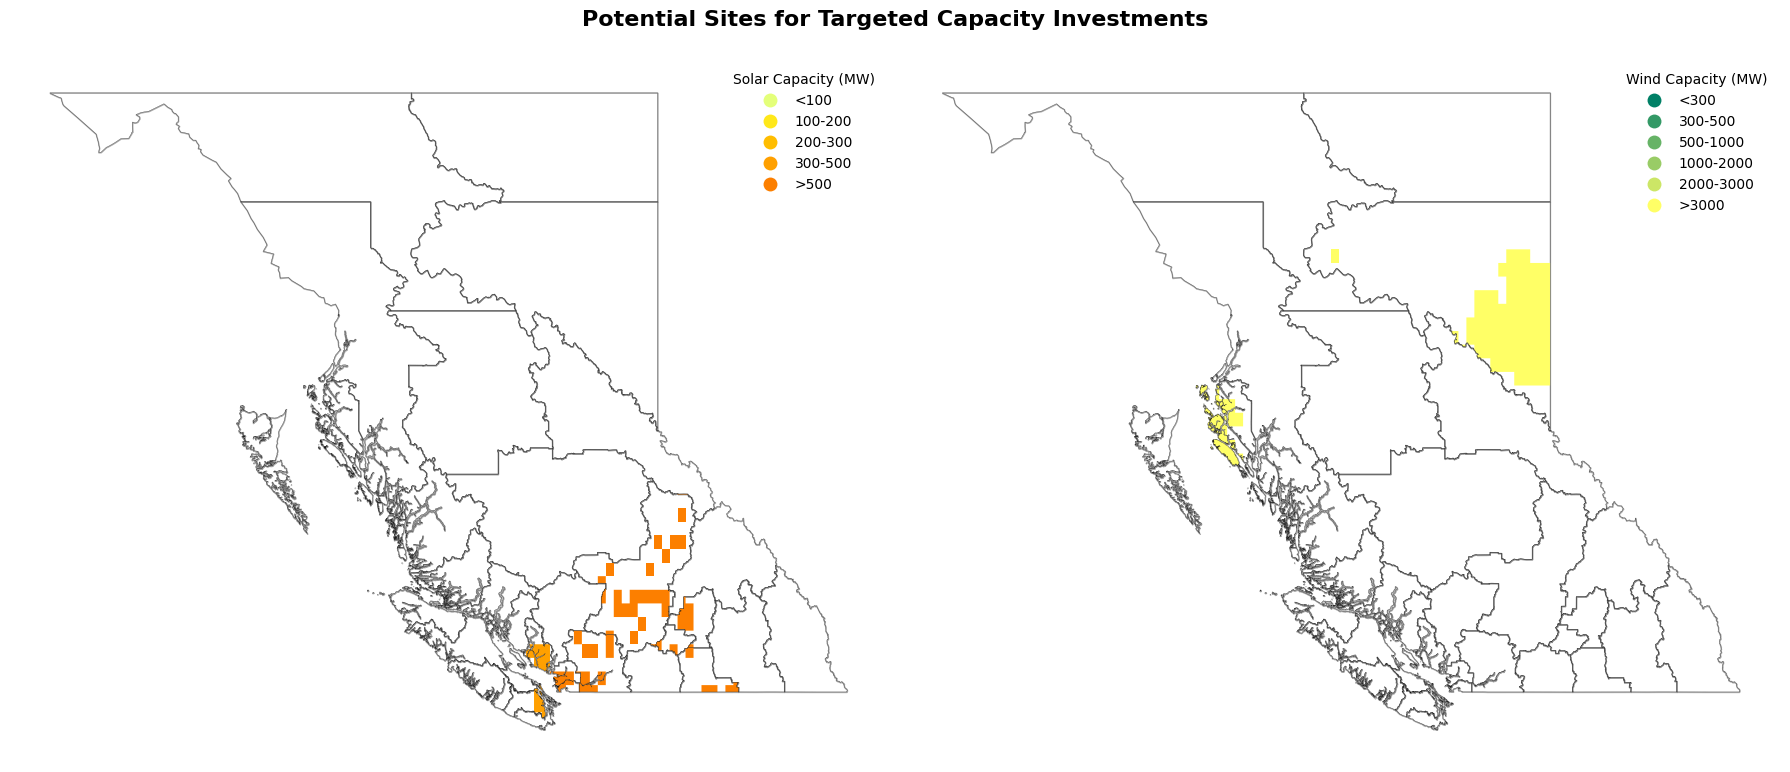

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
legend_x_ax_offset=1
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()

# Show the side-by-side plot

# plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()

<Axes: >

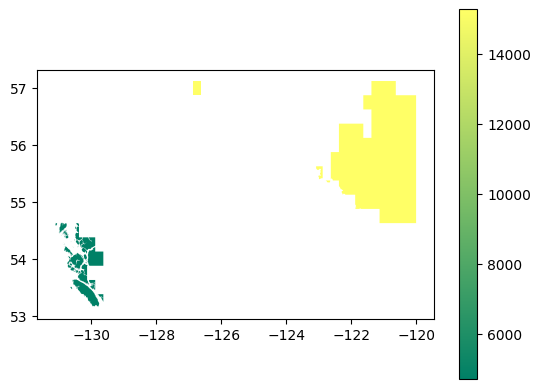

In [13]:
resource_clusters_wind.plot(column='potential_capacity',cmap='summer', legend=True,)